# Импортирование необходимых библиотек

In [1]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

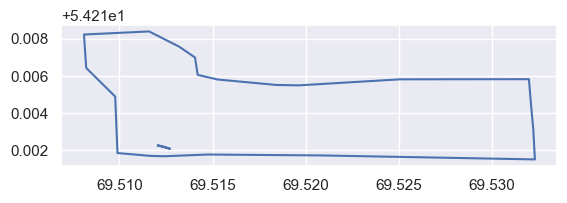

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Составление маски пастбища

In [8]:
aoi_height, aoi_width = pasture_size[-1], pasture_size[0]

In [9]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

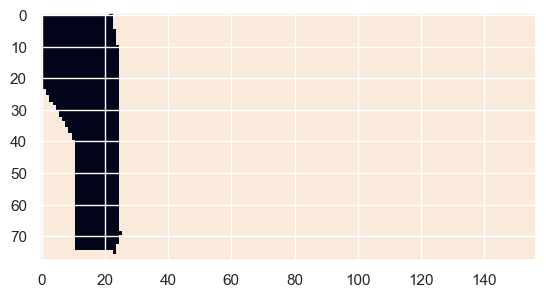

In [10]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

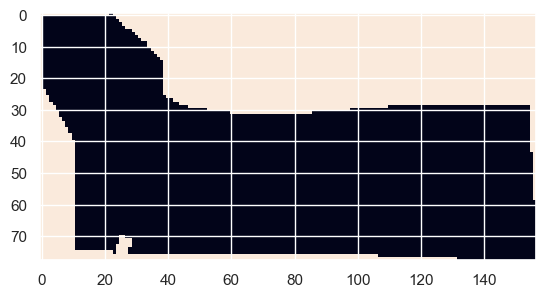

In [11]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [12]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [13]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

In [14]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
    print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
        print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# Подготова данных для обучения

In [15]:
training_df = pd.read_csv("train_data.csv")
training_df

,time,greenmass,zagon
0,2022-06-09,0.80,2
1,2022-06-09,1.00,3
2,2022-06-09,1.20,5
3,2022-06-09,1.10,6
4,2022-07-14,1.40,2
5,2022-07-14,1.20,3
6,2022-08-03,2.20,4
7,2022-08-03,1.90,5
8,2022-08-03,0.90,6
9,2022-08-03,0.60,7


# История погоды по заданному диапазону

In [16]:
start_date = "2022-05-01" 
end_date = "2023-08-31"

In [17]:
Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"

In [18]:
Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)

URL updated:  https://archive-api.open-meteo.com/v1/archive?latitude=54.21495200000001&longitude=69.52020049999999&start_date=2022-05-01&end_date=2023-08-31&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto


In [19]:
history_json_obj = make_API_request(Hist_URL)

Successfull API request!


In [20]:
history_df = pd.DataFrame(history_json_obj["daily"])

In [21]:
history_df

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2022-05-01,12.8,5.2,8.0,1.2,1.4,1.4,0.0,4.0,53,2022-05-01T05:44,2022-05-01T20:53,21.1,34,12.84,2.68
1,2022-05-02,12.0,1.1,7.9,-2.1,0.6,0.6,0.0,2.0,53,2022-05-02T05:42,2022-05-02T20:55,24.0,308,20.68,2.94
2,2022-05-03,14.3,-2.5,9.0,-6.5,0.0,0.0,0.0,0.0,2,2022-05-03T05:40,2022-05-03T20:57,18.1,278,21.98,3.78
3,2022-05-04,16.9,0.7,12.2,-3.4,0.0,0.0,0.0,0.0,3,2022-05-04T05:38,2022-05-04T20:58,17.7,144,22.59,4.39
4,2022-05-05,19.1,9.4,16.6,4.9,0.0,0.0,0.0,0.0,3,2022-05-05T05:36,2022-05-05T21:00,15.8,166,17.20,3.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2023-08-27,19.0,8.8,17.0,7.6,0.0,0.0,0.0,0.0,3,2023-08-27T06:20,2023-08-27T20:26,13.4,56,15.67,2.64
484,2023-08-28,19.1,12.2,16.7,11.1,0.8,0.8,0.0,5.0,51,2023-08-28T06:22,2023-08-28T20:24,13.8,314,11.85,2.26
485,2023-08-29,19.5,11.8,14.6,8.6,1.6,1.6,0.0,4.0,53,2023-08-29T06:23,2023-08-29T20:22,30.8,155,7.85,2.85
486,2023-08-30,18.2,12.5,16.1,10.0,8.0,8.0,0.0,14.0,61,2023-08-30T06:25,2023-08-30T20:19,27.6,159,10.78,2.23


In [22]:
dates_to_analyze = list(training_df["time"])

In [23]:
history_fraction_df = history_df[history_df['time'].isin(dates_to_analyze)]

In [24]:
history_fraction_df.set_index('time', inplace=True)

In [25]:
history_fraction_df

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,,,,
2022-06-09,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,1,2022-06-09T04:49,2022-06-09T21:52,15.9,243,29.62,6.87
2022-07-14,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,1,2022-07-14T05:06,2022-07-14T21:48,13.4,296,26.31,5.95
2022-08-03,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,15.8,49,25.15,4.80
2023-05-15,19.5,3.7,16.0,0.3,0.0,0.0,0.0,0.0,1,2023-05-15T05:18,2023-05-15T21:18,17.1,292,25.89,4.70
2023-05-22,26.0,9.2,22.9,6.1,0.0,0.0,0.0,0.0,3,2023-05-22T05:07,2023-05-22T21:29,16.3,15,21.89,5.18
2023-06-09,24.7,13.4,22.4,12.3,0.0,0.0,0.0,0.0,3,2023-06-09T04:49,2023-06-09T21:52,15.0,336,24.48,5.25
2023-06-14,23.1,7.5,21.8,5.2,0.0,0.0,0.0,0.0,0,2023-06-14T04:48,2023-06-14T21:56,9.6,311,29.64,5.23
2023-07-04,32.8,19.2,32.4,19.1,0.0,0.0,0.0,0.0,3,2023-07-04T04:55,2023-07-04T21:57,16.8,45,24.74,6.37
2023-07-09,29.1,16.4,30.0,16.6,0.0,0.0,0.0,0.0,2,2023-07-09T05:00,2023-07-09T21:53,12.7,305,23.60,5.10


In [26]:
# history_fraction_df["apparent_temperature_min"].plot(kind='bar', color='skyblue', edgecolor='black')

# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [27]:
def get_date_data(formula_text, date_chosen, zagon, collection, by_pasture=True):

    if collection == "L1C":
        data_collection = DataCollection.SENTINEL2_L1C
    elif collection == "L2A":
        data_collection = DataCollection.SENTINEL2_L2A

    bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
    aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

    evalscript_all_bands = """
        //VERSION=3
        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DN"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in bands_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
    evalscript_all_bands = evalscript_all_bands.format(**settings)


    evalscript_aux_data = """
        //VERSION=3

        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DEGREES"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in aux_data_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
    evalscript_aux_data = evalscript_aux_data.format(**settings)


    time_interval = date_chosen, date_chosen

    search_iterator = catalog.search(
        data_collection,
        bbox=pasture_bbox,
        time=time_interval,
        filter="eo:cloud_cover <= 100",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)

    time_difference = datetime.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)


    all_bands_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_all_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        all_bands_process_requests.append(request)

    aux_data_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_aux_data,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        aux_data_process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)
    all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
    all_bands_data = client.download(all_bands_download_requests)

    client = SentinelHubDownloadClient(config=config)
    aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
    aux_data = client.download(aux_data_download_requests)

    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B01"]],zagon)))

        BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B02"]],zagon)))
        GREEN = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B03"]],zagon)))
        RED = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B04"]],zagon)))

        RED_EDGE1 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B05"]],zagon)))
        RED_EDGE2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B06"]],zagon)))
        RED_EDGE3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B07"]],zagon)))

        NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B08"]],zagon)))
        N_NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B8A"]],zagon)))
        WV = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B09"]],zagon)))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B10"]],zagon)))
        SWIR2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B11"]],zagon)))
        SWIR3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B12"]],zagon)))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])),zagon)

        BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])),zagon)
        GREEN = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])),zagon)
        RED = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])),zagon)

        RED_EDGE1 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])),zagon)
        RED_EDGE2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])),zagon)
        RED_EDGE3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])),zagon)

        NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])),zagon)
        N_NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])),zagon)
        WV = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])),zagon)
        if "B10" in bands_dict:
            SWIR_C = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])),zagon)
        SWIR2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])),zagon)
        SWIR3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])),zagon)

    test_index = eval(formula_text)
    
    test_thresh = test_index.min() 
#     test_thresh = (test_index.max() + test_index.min())/2
    # test_thresh = 0

    test_filter = test_index >= test_thresh; test_mask = ~test_filter
    test_meet = ma.masked_array(test_index, mask=test_mask)

    # lower_bound = -1;  upper_bound = 1
    lower_bound = test_meet.min(); upper_bound = test_meet.max()    
    mask = (test_meet < lower_bound) | (test_meet > upper_bound)
    
    test_meet = ma.masked_array(test_meet, mask=mask)
    
    ep.plot_bands(test_meet, title=f"Канал для даты: {date_chosen} и загона №{zagon}", cmap="viridis")

#     test_meet = test_meet.mean()
    test_meet = ma.median(test_meet)
#     test_meet = test_meet.sum()

#     print(f"Успешно получены каналы для даты: {date_chosen} и загона №{zagon}")
    if "B10" in bands_dict:
        return ["time"] + list(["index"]) + list(aux_data_dict.keys()), [date_chosen, test_meet, SZA, SAA, VZM, VAM]
    else:
        return ["time"] + list(["index"]) + list(aux_data_dict.keys()), [date_chosen, test_meet, SZA, SAA, VZM, VAM]

# Получение данных ДЗЗ по доступным датам

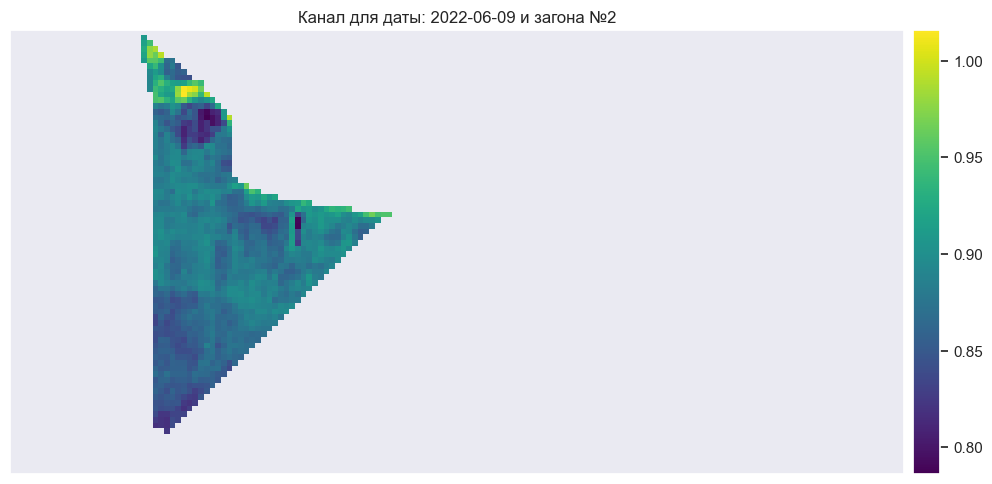

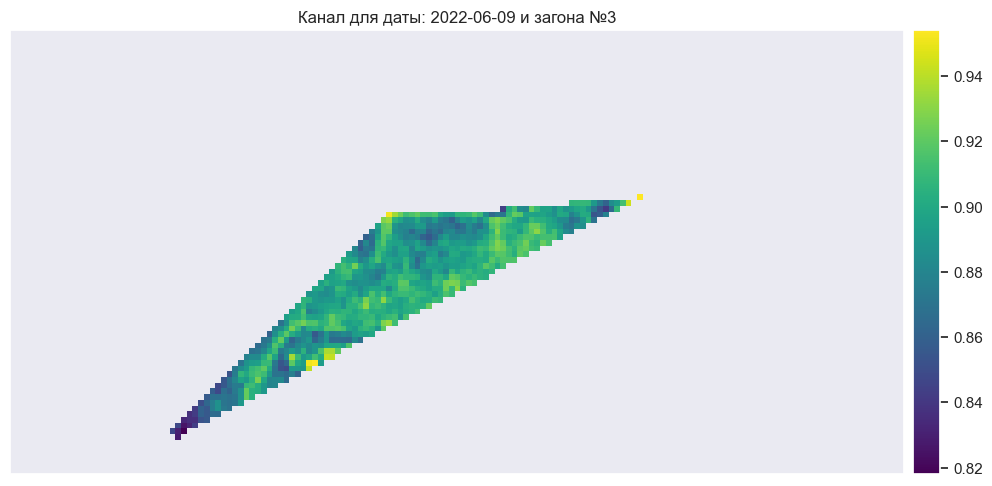

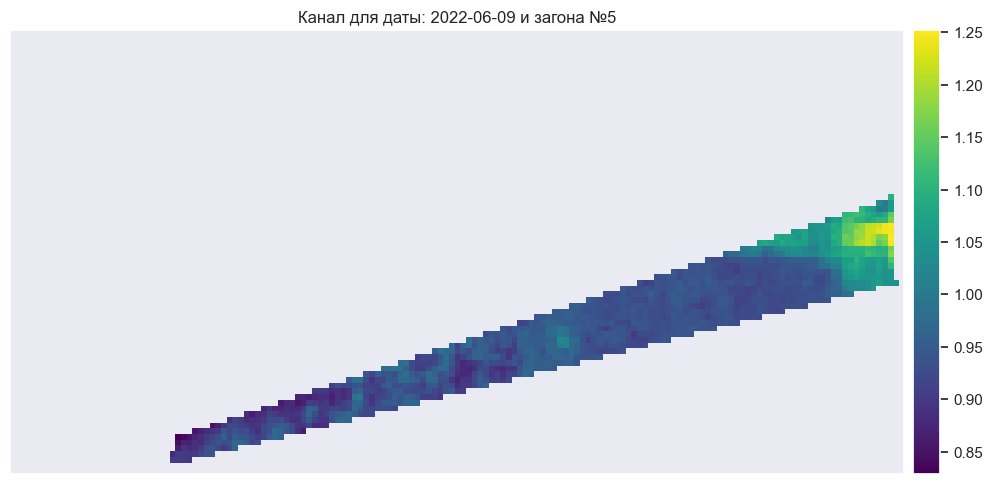

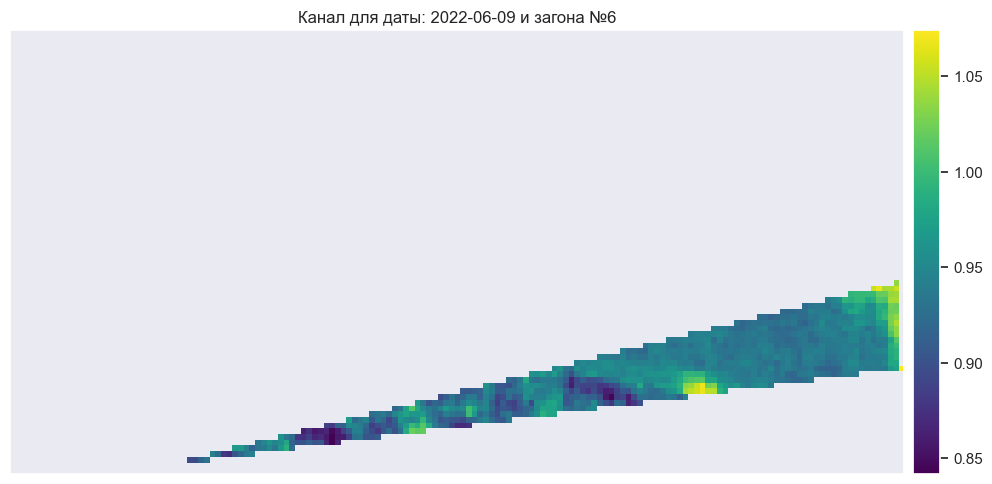

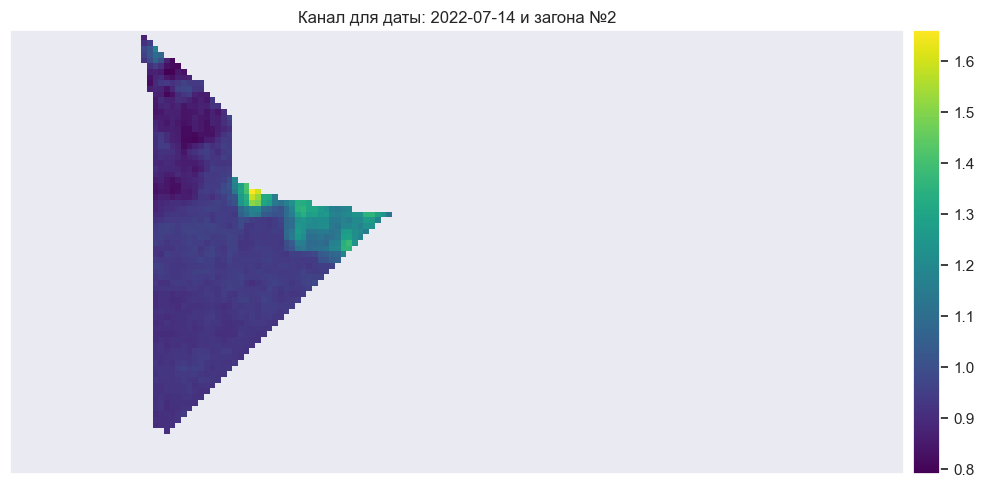

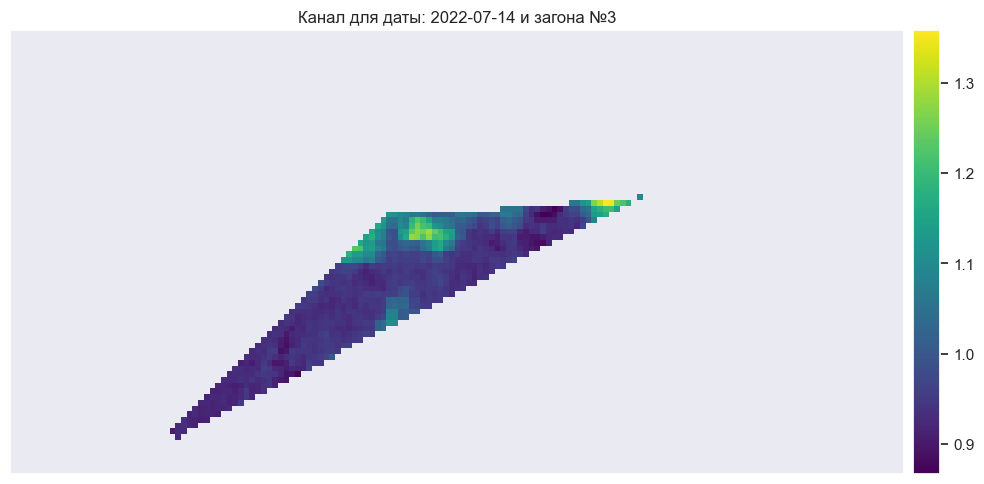

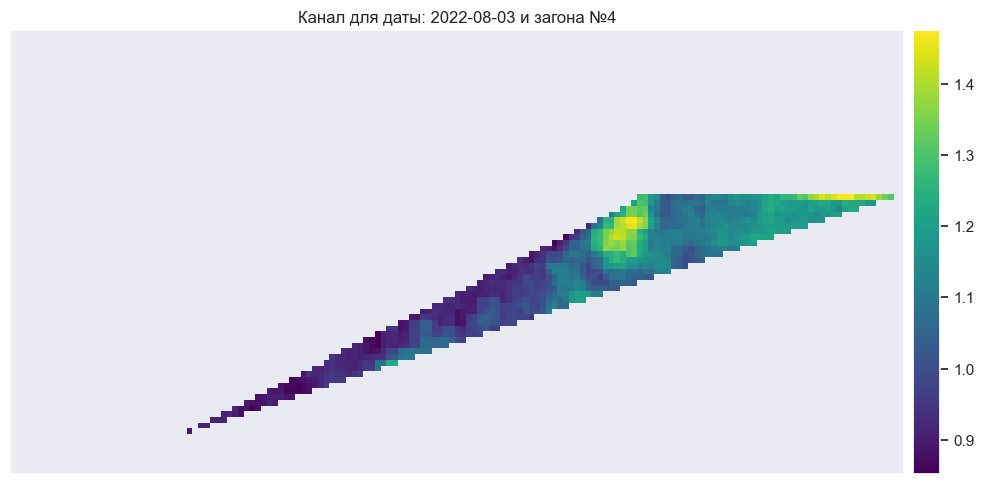

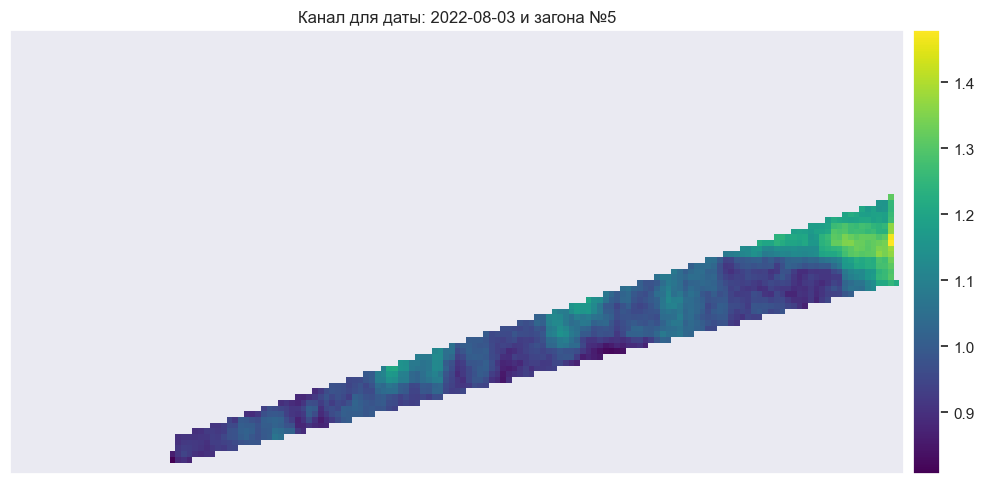

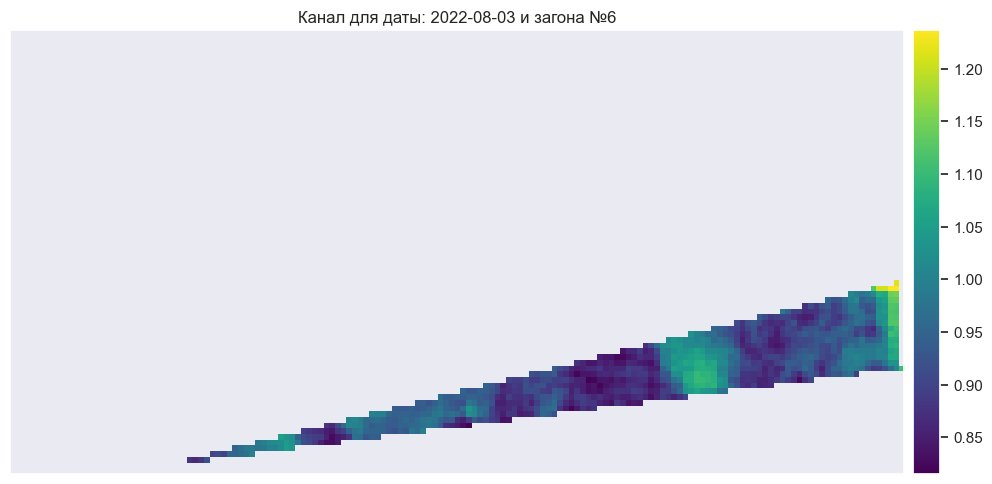

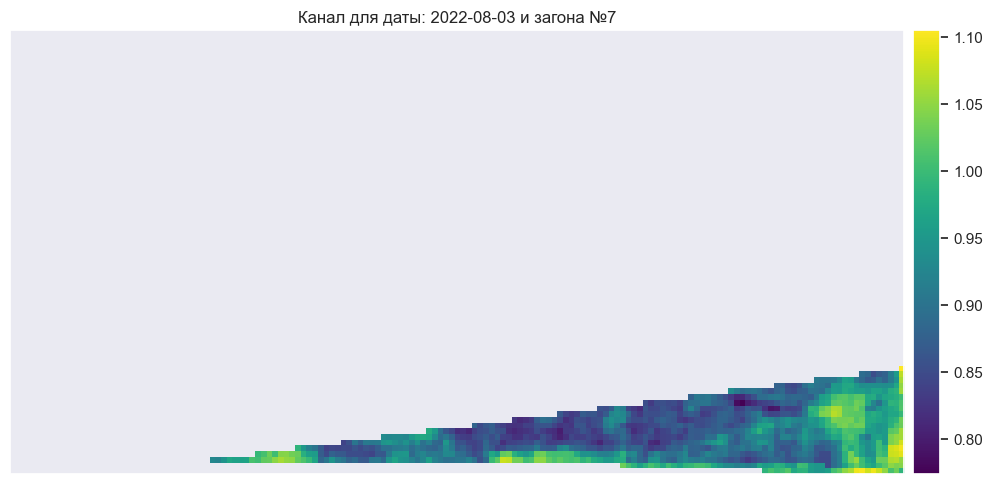

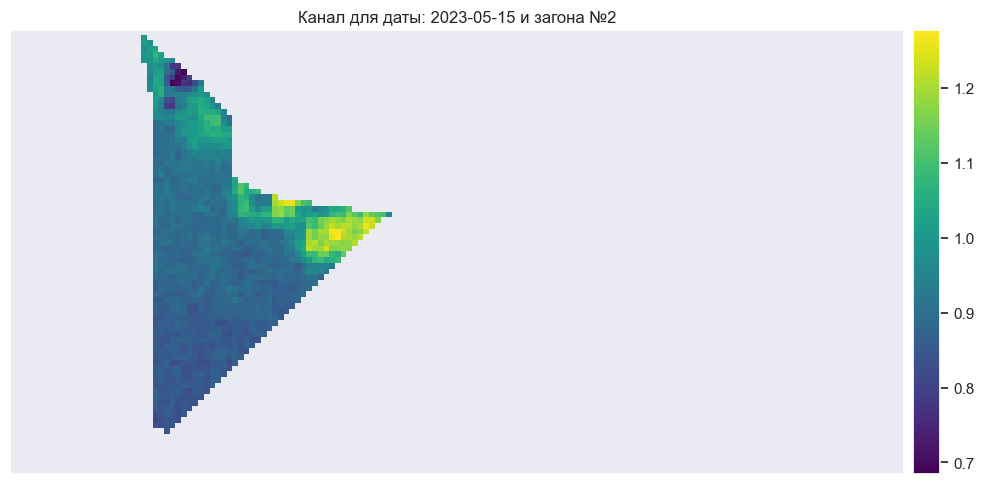

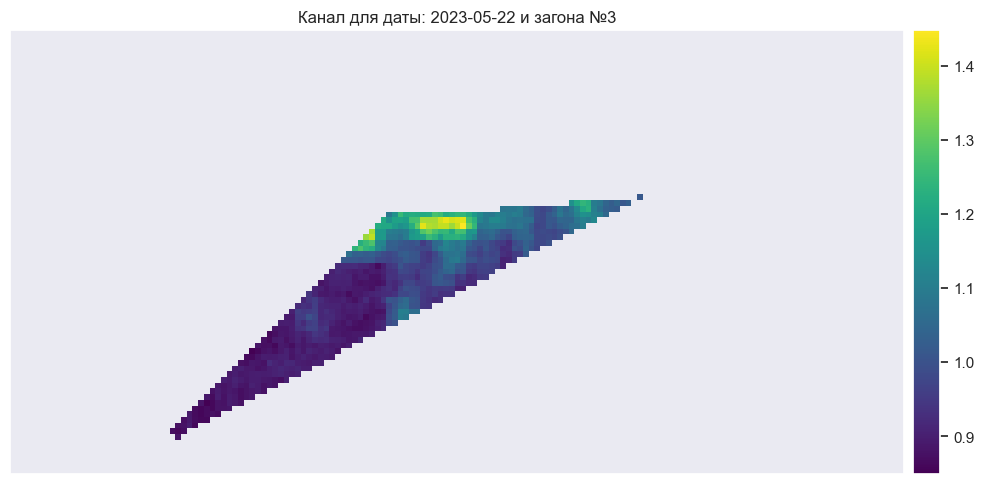

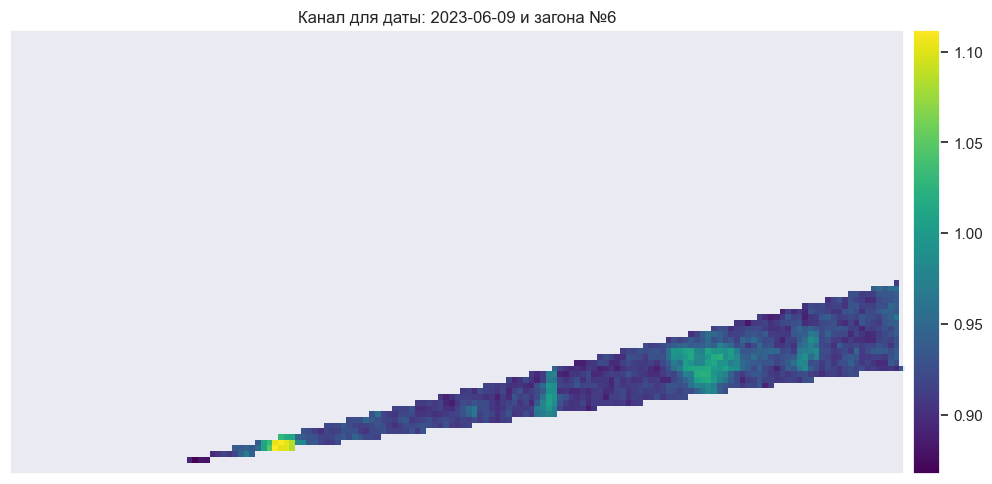

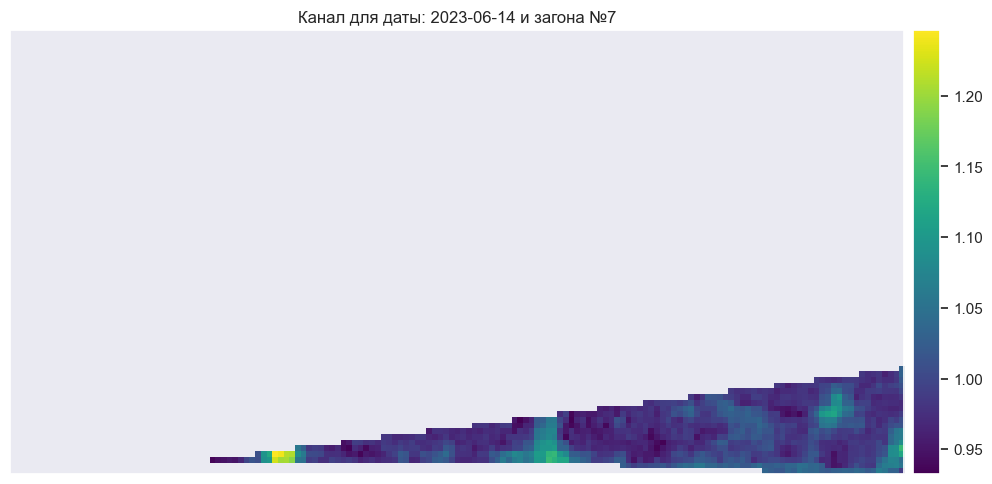

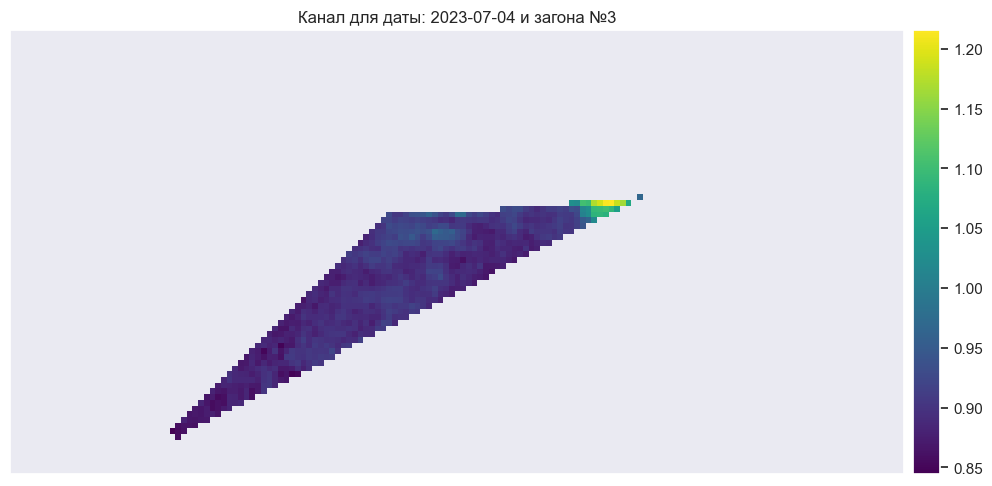

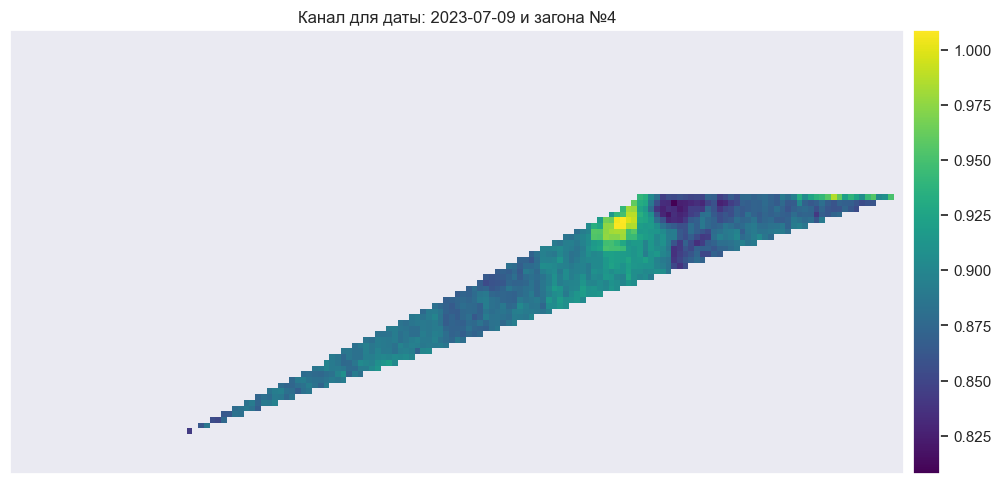

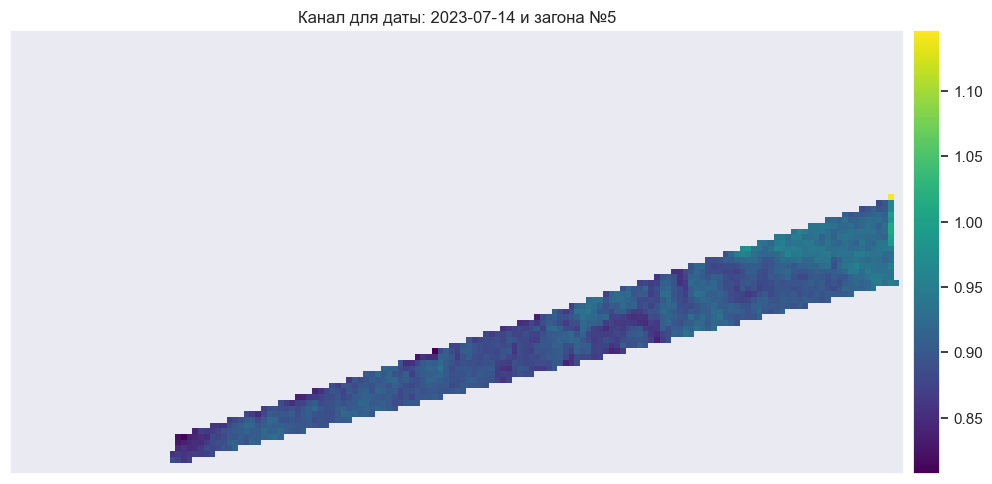

In [28]:
# formula_text = "" # Корреляция: %

# formula_text = "(((NIR-RED)/(NIR+RED))*(1-((SWIR3-SWIR3.min())/(SWIR3.max()-SWIR3.min())))).sum()" # Корреляция: 60%
# formula_text = "(((NIR)/(RED))*((GREEN-RED)+(NIR-SWIR3))).sum()" # Корреляция: 49%
# formula_text = "(((NIR)/(SWIR3))*((GREEN-RED)+(NIR-SWIR3))).sum()" # Корреляция: 43%

# formula_text = "(((NIR-RED)/(NIR+RED))*(1-((SWIR3-SWIR3.min())/(SWIR3.max()-SWIR3.min())))).mean()" # Корреляция: 62%
# formula_text = "(((NIR-SWIR3)/(NIR+SWIR3))*(1-((SWIR3-SWIR3.min())/(SWIR3.max()-SWIR3.min())))).mean()" # Корреляция: 66%
# formula_text = "(((NIR-SWIR3)/(RED+SWIR3))*(1-((SWIR3-SWIR3.min())/(SWIR3.max()-SWIR3.min())))).mean()" # Корреляция: 67%
# formula_text = "(((NIR-SWIR3)/(GREEN+SWIR3))*(1-((SWIR3-SWIR3.min())/(SWIR3.max()-SWIR3.min()))))" # Корреляция: 74%

# formula_text = "(((NIR-SWIR3)/(GREEN+SWIR3))*(1-((GREEN-GREEN.min())/(GREEN.max()-GREEN.min()))))" # Корреляция: 75% (средняя)
# formula_text = "(((NIR-SWIR3)/(GREEN+SWIR3))*(1-((GREEN-GREEN.min())/(GREEN.max()-GREEN.min()))))" # Корреляция: 76% (сумма)
# formula_text = "(WV-SWIR3)/(ULTRA_BLUE+GREEN)" # Корреляция: 80% (сумма)
# formula_text = "(WV-SWIR3)/GREEN" # Корреляция: 81% (сумма)
# formula_text = "np.sqrt((BLUE+WV)/(RED+SWIR3))" # Корреляция: 87% (средняя)
# formula_text = "np.sqrt((BLUE+NIR)/(RED+SWIR3))" # Корреляция: 89% (медианная)
formula_text = "(BLUE+NIR)/(RED+SWIR3)" # Корреляция: 90% (медианная)

sample_form = []
for index in training_df.index:
    data_lables, data_list = get_date_data(formula_text, training_df.loc[index, 'time'], training_df.loc[index, 'zagon'], "L2A", by_pasture=False)
    sample_form.append(data_list)    

In [29]:
indices_df = pd.DataFrame(sample_form, columns=data_lables)
indices_df

,time,index,sunZenithAngles,sunAzimuthAngles,viewZenithMean,viewAzimuthMean
0,2022-06-09,0.876915,32.073795,163.730988,5.205071,271.551331
1,2022-06-09,0.897564,32.073795,163.730988,5.205071,271.551331
2,2022-06-09,0.938503,32.073795,163.730988,5.205071,271.551331
3,2022-06-09,0.937748,32.073795,163.730988,5.205071,271.551331
4,2022-07-14,0.932400,33.603001,161.464020,5.193906,272.806152
5,2022-07-14,0.945482,33.603001,161.464020,5.193906,272.806152
6,2022-08-03,1.066231,37.726006,162.682037,5.156131,272.745392
7,2022-08-03,0.990014,37.726006,162.682037,5.156131,272.745392
8,2022-08-03,0.920662,37.726006,162.682037,5.156131,272.745392
9,2022-08-03,0.900513,37.726006,162.682037,5.156131,272.745392


# Подготовка таблиц

In [30]:
indices_df.drop('time', axis=1, inplace=True)

In [31]:
sample_weather = []
for index in training_df["time"]:
    sample_weather.append(history_df[history_df["time"]==index].values.tolist()[0])
weather_df = pd.DataFrame(sample_weather, columns=history_df.columns.tolist())
weather_df

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2022-06-09,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,1,2022-06-09T04:49,2022-06-09T21:52,15.9,243,29.62,6.87
1,2022-06-09,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,1,2022-06-09T04:49,2022-06-09T21:52,15.9,243,29.62,6.87
2,2022-06-09,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,1,2022-06-09T04:49,2022-06-09T21:52,15.9,243,29.62,6.87
3,2022-06-09,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,1,2022-06-09T04:49,2022-06-09T21:52,15.9,243,29.62,6.87
4,2022-07-14,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,1,2022-07-14T05:06,2022-07-14T21:48,13.4,296,26.31,5.95
5,2022-07-14,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,1,2022-07-14T05:06,2022-07-14T21:48,13.4,296,26.31,5.95
6,2022-08-03,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,15.8,49,25.15,4.80
7,2022-08-03,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,15.8,49,25.15,4.80
8,2022-08-03,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,15.8,49,25.15,4.80
9,2022-08-03,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,15.8,49,25.15,4.80


In [32]:
weather_df.drop(columns=["time", "sunrise", "sunset", "weathercode"], inplace=True)
weather_df

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87
1,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87
2,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87
3,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87
4,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,13.4,296,26.31,5.95
5,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,13.4,296,26.31,5.95
6,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80
7,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80
8,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80
9,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80


In [33]:
training_df.drop(columns=["time"], inplace=True)
input_df = pd.concat([weather_df, indices_df, training_df], axis=1)
input_df

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,index,sunZenithAngles,sunAzimuthAngles,viewZenithMean,viewAzimuthMean,greenmass,zagon
0,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,0.876915,32.073795,163.730988,5.205071,271.551331,0.80,2
1,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,0.897564,32.073795,163.730988,5.205071,271.551331,1.00,3
2,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,0.938503,32.073795,163.730988,5.205071,271.551331,1.20,5
3,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,0.937748,32.073795,163.730988,5.205071,271.551331,1.10,6
4,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,13.4,296,26.31,5.95,0.932400,33.603001,161.464020,5.193906,272.806152,1.40,2
5,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,13.4,296,26.31,5.95,0.945482,33.603001,161.464020,5.193906,272.806152,1.20,3
6,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,1.066231,37.726006,162.682037,5.156131,272.745392,2.20,4
7,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,0.990014,37.726006,162.682037,5.156131,272.745392,1.90,5
8,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,0.920662,37.726006,162.682037,5.156131,272.745392,0.90,6
9,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,0.900513,37.726006,162.682037,5.156131,272.745392,0.60,7


In [45]:
weather_parameters = input_df.drop(columns=["index", "greenmass", "zagon"], inplace=False)
weather_parameters

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,sunZenithAngles,sunAzimuthAngles,viewZenithMean,viewAzimuthMean
0,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,32.073795,163.730988,5.205071,271.551331
1,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,32.073795,163.730988,5.205071,271.551331
2,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,32.073795,163.730988,5.205071,271.551331
3,26.1,14.2,23.4,12.4,0.0,0.0,0.0,0.0,15.9,243,29.62,6.87,32.073795,163.730988,5.205071,271.551331
4,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,13.4,296,26.31,5.95,33.603001,161.464020,5.193906,272.806152
5,30.4,16.5,30.8,16.6,0.0,0.0,0.0,0.0,13.4,296,26.31,5.95,33.603001,161.464020,5.193906,272.806152
6,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,37.726006,162.682037,5.156131,272.745392
7,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,37.726006,162.682037,5.156131,272.745392
8,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,37.726006,162.682037,5.156131,272.745392
9,23.9,12.8,22.7,11.7,0.0,0.0,0.0,0.0,15.8,49,25.15,4.80,37.726006,162.682037,5.156131,272.745392


In [52]:
weights = {
    'temperature_2m_max': 0.9,
    'temperature_2m_min': 0.9,
    'apparent_temperature_max': 0.9,
    'apparent_temperature_min': 0.9,
    'precipitation_sum': 0.9,
    'rain_sum': 0.9,
    'snowfall_sum': 0.1,
    'precipitation_hours': 0.1,
    'windspeed_10m_max': 0.1,
    'winddirection_10m_dominant': 0.1,
    'shortwave_radiation_sum': 0.9,
    'et0_fao_evapotranspiration': 0.9,
    'sunZenithAngles': 1,
    'sunAzimuthAngles': 1,
    'viewZenithMean': 0.9,
    'viewAzimuthMean': 0.9,
}

weighted_vector = (weather_parameters * pd.Series(weights)).sum(axis=1)

# Анализ перед обучением

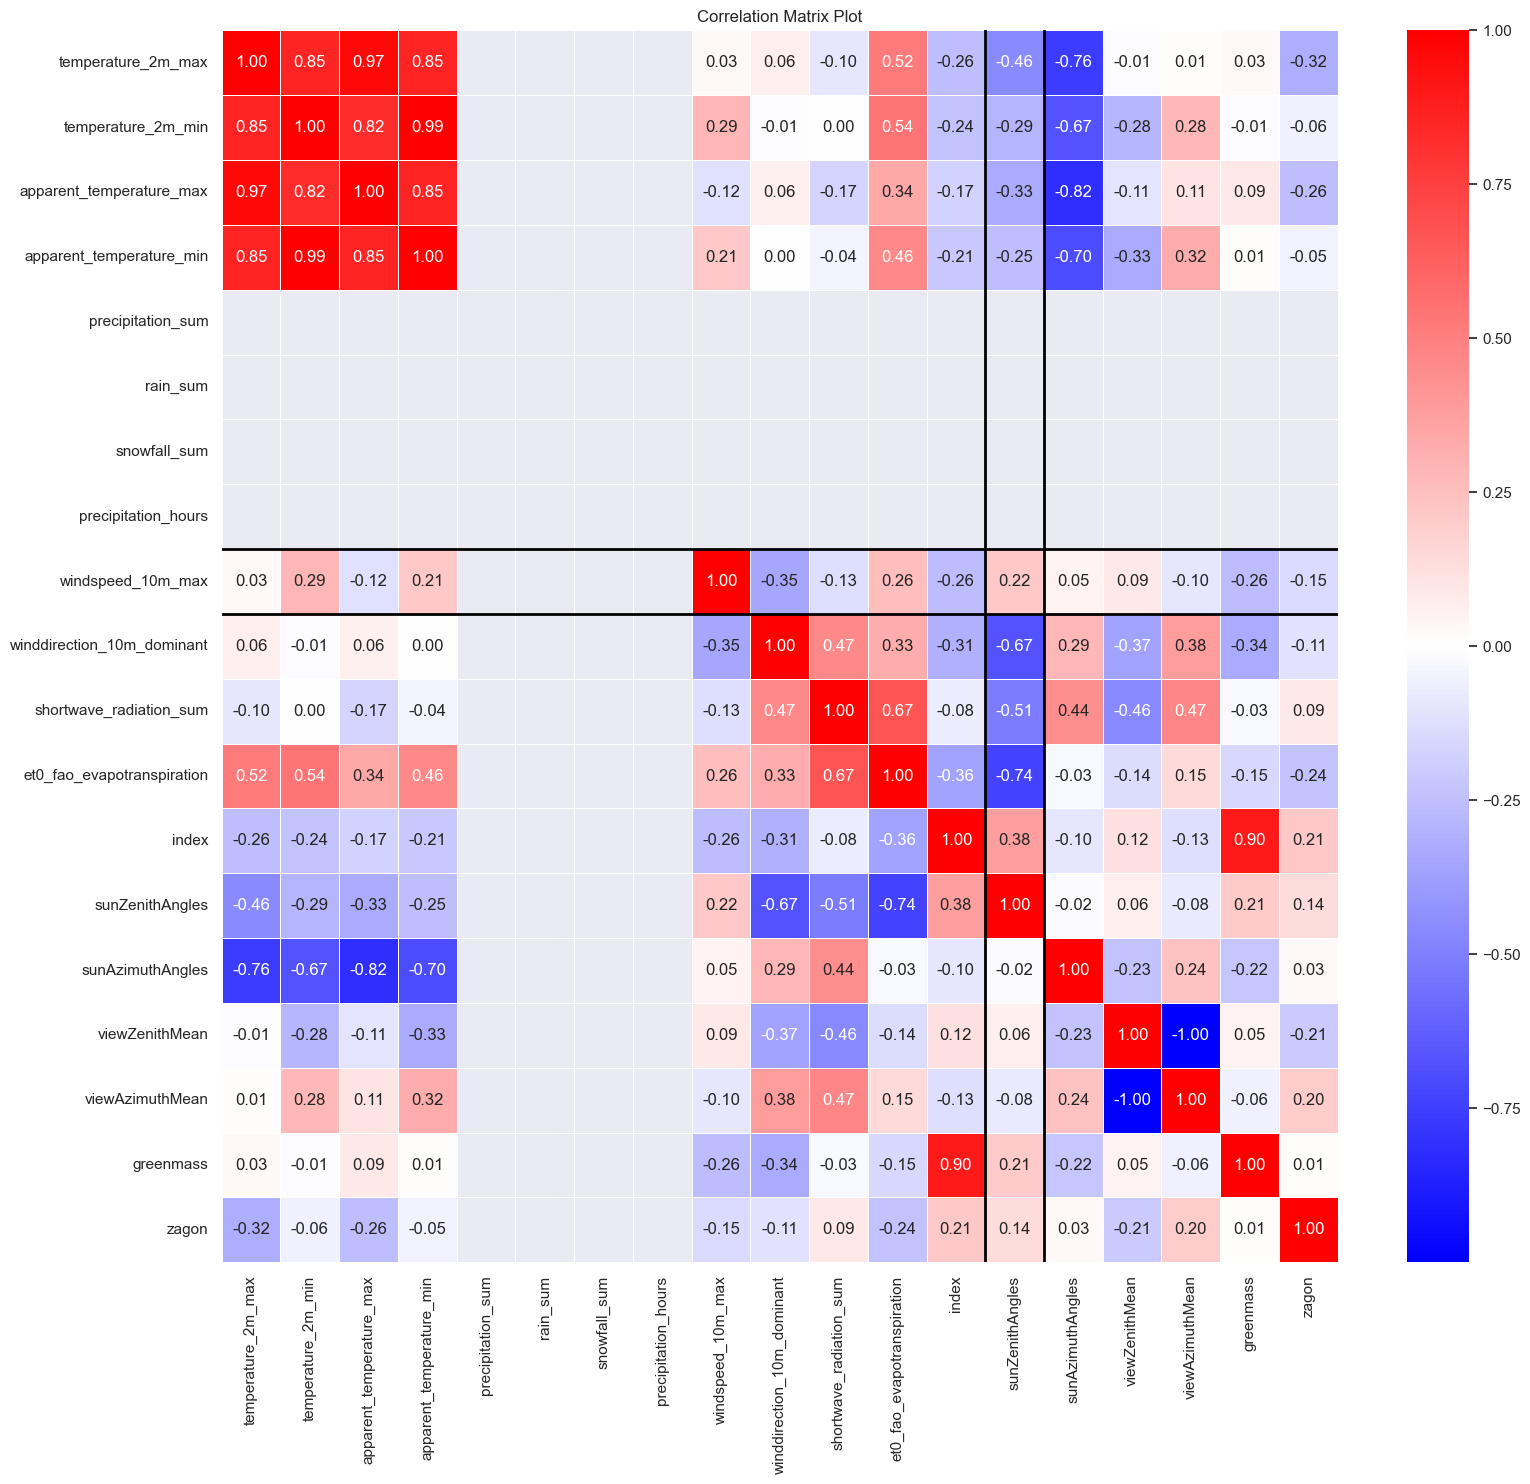

In [34]:
# Calculate the correlation matrix
correlation_matrix = input_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt=".2f", linewidths=.5)

plt.axvline(x=13, color='black', linewidth=2)
plt.axvline(x=14, color='black', linewidth=2)

plt.axhline(y=8, color='black', linewidth=2)
plt.axhline(y=9, color='black', linewidth=2)

plt.title("Correlation Matrix Plot")
plt.show()

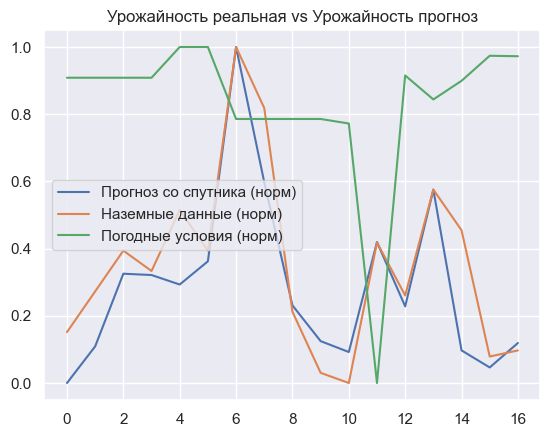

In [53]:
n_x = (input_df["index"] - input_df["index"].min())/(input_df["index"].max() - input_df["index"].min())
n_y = (input_df["greenmass"] - input_df["greenmass"].min())/(input_df["greenmass"].max() - input_df["greenmass"].min())
n_z = (weighted_vector - weighted_vector.min())/(weighted_vector.max() - weighted_vector.min())

plt.plot(range(len(input_df.index)), n_x, label='Прогноз со спутника (норм)')
plt.plot(range(len(input_df.index)), n_y, label='Наземные данные (норм)')
plt.plot(range(len(weighted_vector.index)), n_z, label='Погодные условия (норм)')
# plt.plot(range(len(input_df.index)), input_df["sunZenithAngles"], label='SZA')

plt.title('Урожайность реальная vs Урожайность прогноз')
plt.legend()
plt.show()

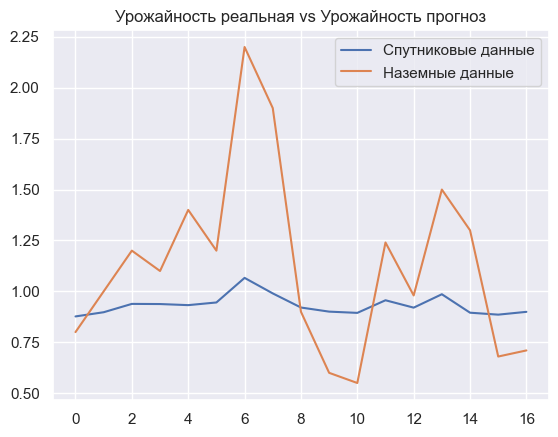

In [55]:
plt.plot(range(len(input_df.index)), input_df["index"], label='Спутниковые данные')
plt.plot(range(len(input_df.index)), input_df["greenmass"], label='Наземные данные')
# plt.plot(range(len(weighted_vector.index)), weighted_vector, label='Погодные условия')
# plt.plot(range(len(input_df.index)), input_df["sunZenithAngles"], label='SZA')
# plt.axhline(y=(input_df["index"]).mean(), color='r', linestyle='--', label='Среднее спутник')
# plt.axhline(y=(input_df["greenmass"]).mean(), color='g', linestyle='--', label='Среднее наземные')

plt.title('Урожайность реальная vs Урожайность прогноз')
plt.legend()
plt.show()

In [37]:
input_df[["index", "greenmass", "zagon"]]

,index,greenmass,zagon
0,0.876915,0.80,2
1,0.897564,1.00,3
2,0.938503,1.20,5
3,0.937748,1.10,6
4,0.932400,1.40,2
5,0.945482,1.20,3
6,1.066231,2.20,4
7,0.990014,1.90,5
8,0.920662,0.90,6
9,0.900513,0.60,7


In [38]:
(input_df["index"]/input_df["greenmass"]).mean()

0.933127763773941

In [39]:
input_df["index"] * (input_df["index"]/input_df["greenmass"]).mean()

0     0.818274
1     0.837542
2     0.875743
3     0.875039
4     0.870049
5     0.882256
6     0.994930
7     0.923810
8     0.859095
9     0.840294
10    0.834564
11    0.892391
12    0.858554
13    0.919919
14    0.835411
15    0.826454
16    0.839306
Name: index, dtype: float64

In [40]:
np.corrcoef(input_df["greenmass"], input_df["index"] * (input_df["index"]/input_df["greenmass"]).mean())[0, 1]

0.8950210627753502

In [41]:
print(input_df["index"].var(), input_df["index"].std())

0.0022864764849381694 0.04781711497924325


In [42]:
print(input_df["greenmass"].var(), input_df["greenmass"].std())

0.19978455882352944 0.44697266004033115


In [43]:
# new_max = input_df["greenmass"].max()
# new_min = input_df["greenmass"].min()

# input_df["mapped_index"] = new_min + (input_df["index"] - input_df["index"].min()) / (input_df["index"].max() - input_df["index"].min()) * (new_max - new_min)
# input_df[["index", "mapped_index", "greenmass", "zagon"]]

Slope: 8.37
Intercept: -6.66
Cреднеквадратичная ошибка (RMSE): 0.02
Коэффициент детерминации (R^2): 1.00


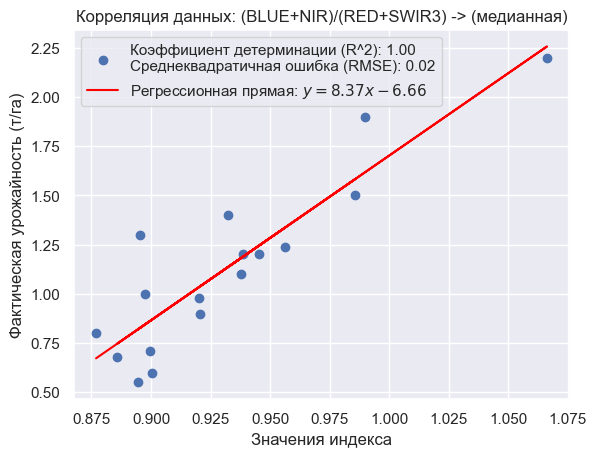

In [66]:
# Assuming value_x and value_y are your new variable names
value_x = input_df["index"]
value_y = input_df["greenmass"]

# Assuming value_x and value_y are your new variable names
coefficients = np.polyfit(value_x, value_y, 1)
slope, intercept = coefficients
regression_line = slope * value_x + intercept

distances = np.abs(value_y - (slope * value_x + intercept)) / np.sqrt(slope**2 + 1)
mean_distance = np.mean(distances)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(distances**2))

# R-squared (coefficient of determination)
mean_y = np.mean(value_y)
ss_total = np.sum((value_y - mean_y)**2)
ss_residual = np.sum(distances**2)
r_squared = 1 - (ss_residual / ss_total)

# Print the results
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"Cреднеквадратичная ошибка (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r_squared:.2f}")

plt.scatter(value_x, value_y, marker='o', linestyle='-', label=f'Коэффициент детерминации (R^2): {r_squared:.2f}\nCреднеквадратичная ошибка (RMSE): {rmse:.2f}')
plt.plot(value_x, regression_line, color='red', label=f'Регрессионная прямая: $y = {slope:.2f}x {intercept:.2f}$')

plt.xlabel('Значения индекса')
plt.ylabel('Фактическая урожайность (т/га)')
plt.title('Корреляция данных: (BLUE+NIR)/(RED+SWIR3) -> (медианная)')

plt.legend()
plt.show()

In [83]:
import plotly.express as px
import pandas as pd

def normalize_vector(vector):
    min_val = vector.min()
    max_val = vector.max()
    return (vector - min_val) / (max_val - min_val)

# Assuming value_x, value_y, and value_z are your variable names
value_x = input_df["index"]
value_y = input_df["greenmass"]
value_z = weighted_vector  # Replace third_vector with the actual name of your third vector

# Normalize the vectors
normalized_x = normalize_vector(value_x)
normalized_y = normalize_vector(value_y)
normalized_z = normalize_vector(value_z)

# Create an interactive 3D scatter plot with Plotly using normalized values
fig = px.scatter_3d(x=normalized_x, y=normalized_y, z=normalized_z, labels={'x': 'Значения индекса (спутник)', 'y': 'Реальные значения урожайности (т/га)', 'z': 'Погодные условия'})
fig.update_layout(scene=dict(aspectmode="data"))
fig.show()


Correlation Plane Formula: Green Mass = 8.59 * Index + 0.20 * Normalized Weather Conditions + -7.04


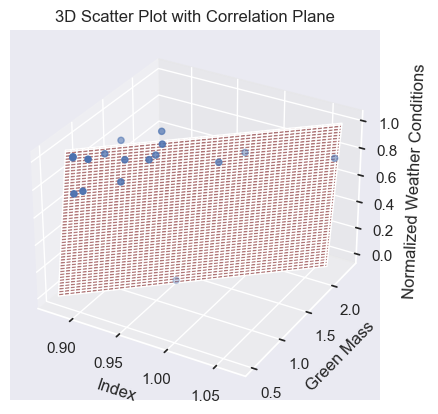

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Assuming value_x, value_y, and weighted_vector are your vectors
value_x = input_df["index"].values.reshape(-1, 1)
value_y = input_df["greenmass"].values
value_z = normalize(weighted_vector.values)

# Combine value_x and value_z into a matrix for multivariate regression
X = np.column_stack((value_x, value_z))

# Fit a multivariate linear regression model
model = LinearRegression()
model.fit(X, value_y)

# Extract coefficients
slope_x, slope_z = model.coef_
intercept = model.intercept_

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the three vectors
ax.scatter(value_x.flatten(), value_y, value_z, marker='o', label='Data Points')

# Create a meshgrid for the plane
x_plane = np.linspace(min(value_x.flatten()), max(value_x.flatten()), 100)
z_plane = np.linspace(min(value_z), max(value_z), 100)
x_plane, z_plane = np.meshgrid(x_plane, z_plane)

# Calculate corresponding y values for the plane using regression coefficients
y_plane = slope_x * x_plane + slope_z * z_plane + intercept

# Plot the plane using plot_surface
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.5, color='red', label='Correlation Plane')

# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Green Mass')
ax.set_zlabel('Normalized Weather Conditions')
ax.set_title('3D Scatter Plot with Correlation Plane')

print(f"Correlation Plane Formula: Green Mass = {slope_x:.2f} * Index + {slope_z:.2f} * Normalized Weather Conditions + {intercept:.2f}")
plt.show()

In [102]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Assuming value_x, value_y, and weighted_vector are your vectors
value_x = input_df["index"].values
value_y = input_df["greenmass"].values
value_z = normalize(weighted_vector.values)

# Combine value_x and value_z into a DataFrame
df = pd.DataFrame({'Index': value_x, 'GreenMass': value_y, 'NormalizedWeather': value_z})

# Fit a multivariate linear regression model
model = np.polyfit(df['Index'], df['GreenMass'], 1)
slope_x, slope_z = model
intercept = np.mean(df['GreenMass']) - slope_x * np.mean(df['Index']) - slope_z * np.mean(df['NormalizedWeather'])

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='Index', y='GreenMass', z='NormalizedWeather',
                    labels={'Index': 'Index', 'GreenMass': 'Green Mass', 'NormalizedWeather': 'Normalized Weather'})

# Create a meshgrid for the plane
x_plane = np.linspace(min(df['Index']), max(df['Index']), 100)
z_plane = np.linspace(min(df['NormalizedWeather']), max(df['NormalizedWeather']), 100)
x_plane, z_plane = np.meshgrid(x_plane, z_plane)

# Calculate corresponding y values for the plane using regression coefficients
y_plane = slope_x * x_plane + slope_z * z_plane + intercept

# Plot the plane using go.Surface
fig.add_trace(go.Surface(x=x_plane, y=y_plane, z=z_plane, opacity=0.5, colorscale='Viridis'))

# Print the formula of the correlation plane
formula = f"Green Mass = {slope_x:.2f} * Index + {slope_z:.2f} * Normalized Weather Conditions + {intercept:.2f}"
print(f"Correlation Plane Formula: {formula}")

# Show the plot
fig.show()


Correlation Plane Formula: Green Mass = 8.37 * Index + -6.66 * Normalized Weather Conditions + -1.12


In [105]:
check_vector = []
for Index, NWC, GM in zip(input_df["index"], normalize(weighted_vector), input_df["greenmass"]):
#     check_vector.append(8.37 * Index + -6.66 * NWC + -1.12)
    check_vector.append(8.59 * Index + 0.20 * NWC + -7.04)

In [106]:
mse = np.mean((np.array(check_vector) - np.array(input_df["greenmass"]))**2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.03563753790538586


In [108]:
for c, b in zip(check_vector, input_df["greenmass"]):
    print(abs(c-b))

0.12558934424210233
0.14821992967415465
0.003447900077814703
0.09696746673297385
0.23068205356598037
0.08169358611106703
0.07608224747885295
0.27861918570291033
0.12564635811556302
0.2525695842336516
0.2471258854717424
0.06500445544719713
0.06658545979561259
0.09719264959577689
0.4696670764771096
0.08279251519404485
0.1708202048463363
